<a href="https://colab.research.google.com/github/ethan-yoo/2022_aiffel_exp/blob/main/E07_3LineSummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E07. 뉴스기사 요약봇 만들기**
> 뉴스기사는 아래의 것을 사용합니다.
>
>https://github.com/sunnysai12345/News_Summary

## **Index 😉**

01. 데이터 가져오기
02. 데이터 전처리
- 

---

## **01. 데이터 가져오기**

In [1]:
# 필요한 함수 가져오기

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('Done!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Done!


In [2]:
# 데이터 가져오기

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.shape

(98401, 2)

📰 총 98401개의 열, 2개의 컬럼을 가진 데이터입니다.

10개 라인을 뽑아서 샘플로 살펴보겠습니다.

In [4]:
data.sample(10)

,headlines,text
71919,Printing retail chain Printo acquires rival Pr...,Bengaluru-based printing retail chain Printo h...
50909,Delhi-based brand accuses Dior of plagiarism,Delhi-based garment retailer People Tree has a...
83888,Uber hires law firm to probe Indian rape victi...,Uber has hired law firm O'Melveny & Myers to i...
82187,Music fest's next edition cancelled over repor...,"The upcoming edition of BrÃÂ¥valla, Sweden's ..."
27339,"Sindhu wins match on b'day, enters quarters of...","World number three shuttler PV Sindhu, who is ..."
61082,Rajput group vandalise mall over Padmavati tra...,Members of the Rajput organisation Karni Sena ...
29227,"Ziva doesn't care about trophy, wants to run o...",In an Instagram post after winning the IPL tit...
90117,"Chennai road caves in, second such instance in...",A portion of road near Taylor's road-EVR junct...
66987,RBI to allow fund transfer among mobile wallets,The Reserve Bank of India has said that intero...
76792,"Putin uses good sunblock, tweets user on his s...",Reacting to Russian President Vladimir Putin's...


📰 헤드라인과 본문으로 나뉘어 있습니다.

추상적 요약을 하려면 본문을 보면서 헤드라인을 참고하고,

추출적 요약을 하려면 본문만 보면 되겠네요.

---

## **02-1. 중복 데이터 제거 & 텍스트 정규화**

In [5]:
print('text 열에서 중복 없는 유일한 샘플의 수 :', data['text'].nunique())
print('healines 열에서 중복 없는 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복 없는 유일한 샘플의 수 : 98360
healines 열에서 중복 없는 유일한 샘플의 수 : 98280


📰 헤드라인과 본문 양쪽 모두 중복 데이터가 존재합니다.

헤드라인은 중복될 수 있을 것 같지만, 본문에 중복된 내용은 필요 없으니 지워주도록 하겠습니다.

In [6]:
# inplace=True 면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접 변환
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


📰 전체 샘플 수가 본문의 unique 데이터 개수에 맞춰졌네요.

혹시 중복 데이터 중에 null 값이 있었는지 확인해 보겠습니다.

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


📰 다행히 null값은 없었나 봅니다. 전처리를 계속 진행합니다.

In [8]:
# 효율적인 데이터 처리를 위한 텍스트 정규화

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


📰 텍스트 정규화 참고 링크: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

앞에서 다운로드 받았던 불용어 리스트를 이용해서 불용어 처리까지 진행합니다.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 불용어 처리 함수 생성

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)

    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('Done!')

Done!


📰 헤드라인에서는 따로 불용어 제거 처리를 해주지 않습니다.

요약 문장이니 굳이 할 필요가 없습니다.

In [11]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 (오래 걸림)
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리(오래 걸림)
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("healines 전처리 후 결과: ", clean_headlines[:5])

healines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


📰 전처리 후 혹시 빈 문장은 없는지 확인합니다.

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

📰 따로 빈 문장은 없는 것 같군요.

---

### **02-2. 데이터 길이 정하기**

- 훈련용 데이터와 테스트용 데이터를 나누기 전에 사용할 문장 길이를 정해야 합니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


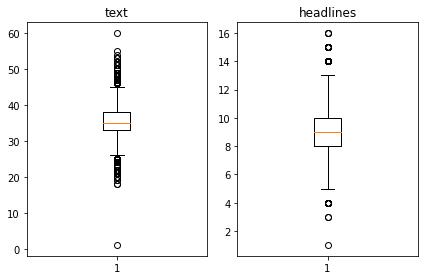

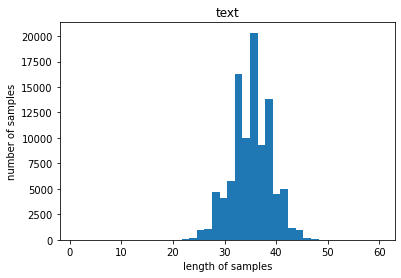

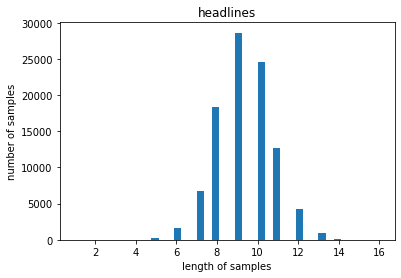

In [14]:
# 길이 분포 출력하기
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

📰 텍스트는 평균 36, 헤드라인은 평균 10 정도의 길이를 갖습니다.

따라서 텍스트 50, 헤드라인 15 정도로 문장 길이를 설정해 주겠습니다.

In [15]:
text_max_len = 50
headlines_max_len = 15

print('Done!')

Done!


📰 설정한 문장 길이에 맞춰 데이터를 처리하면 얼마나 데이터 손실이 발생하는지 확인해 보겠습니다.

In [16]:
# 데이터 처리 함수 생성

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

print('Done!')

Done!


In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


📰 99.9% 가까이 처리 가능하군요.


In [18]:
# 0.1%의 나머지 문장 빼고 처리

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98343


📰 전체 98360개의 데이터 중 98343개가 남았습니다. 17개 데이터가 0.1%에 해당했군요.

---

### **02-3. 토큰 처리 & ndarray 변환**

- 문장 처리에 필요한 start, end 토큰 처리를 해 줍니다.

In [19]:
# 추상적 요약에 필요한 학습 데이터는 헤드라인이기 때문에
# 헤드라인 데이터에 시작/종료 토큰 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


📰 DataFrame 구조의 데이터를 ndarray로 변환해줍니다.

In [20]:
# 인코더 인풋
encoder_input = np.array(data['text'])

# 디코더 인풋
decoder_input = np.array(data['decoder_input'])

# 디코더 레이블
decoder_target = np.array(data['decoder_target'])

print('Done!')

Done!


---

### **02-4. 데이터 분리하기**

- 훈련 데이터와 학습 데이터를 분리합니다.

In [21]:
# train_test_split을 사용하는 대신 직접 잘라봅니다.

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

print(indices)

[90945 87923  6399 ... 20293 17071 63694]


In [22]:
# 각 데이터의 샘플 순서를 정의해 줍니다.

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print('Done!')

Done!


In [23]:
# 8:2 비율로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19668


📰 전체 데이터 수가 98343개였으니, 8:2로 잘 나눠진 것을 확인할 수 있습니다.

이제 데이터를 넣어주기만 하면 되겠죠.

In [24]:
# 데이터 입력

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


📰 잘 들어간 것 같습니다. 이제 각 데이터를 벡터 변환만 해주면 전처리가 끝나겠죠?

---

### **02-5. 토큰화하기**

- Keras의 tokenizer를 사용합니다.

In [25]:
src_tokenizer = Tokenizer()

# 데이터에서 단어 집합 생성
src_tokenizer.fit_on_texts(encoder_input_train)

print('Done!')

Done!


📰 빈도 수가 낮은 데이터를 없애면 정확도가 오를까요?

In [26]:
# 7회 미만 데이터 제거
threshold = 7

# 단어 수
total_cnt = len(src_tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69529
등장 빈도가 6번 이하인 희귀 단어의 수: 47388
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22141
단어 집합에서 희귀 단어의 비율: 68.15573357879447
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.478572391079762


📰 흠, 생성한 단어 사전에서 68%의 단어들을 날려버려야 하지만, 전체 등장 빈도 중에서는 3.5%밖에 되지 않습니다.

굳이 남겨두지 않아도 될 것 같으니 제거해 줍니다.

In [27]:
# 6회 이하 단어 제거한 사전 크기
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab)

# 단어 집합 재생성
src_tokenizer.fit_on_texts(encoder_input_train)

print('Done!')

Done!


In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[15, 21, 1093, 12601, 11292, 87, 6573, 1284, 7, 9848, 1444, 18359, 243, 1888, 1079, 645, 2448, 3792, 5328, 18359, 18359, 5328, 9848, 1444, 23, 15974, 1079, 10, 1, 15, 11292, 974, 10, 106, 1429, 560, 1251], [415, 270, 8530, 3538, 766, 1089, 8115, 8984, 6904, 2547, 117, 793, 943, 31, 3, 13, 407, 666, 180, 17, 178, 1502, 415, 68, 1200, 2610, 2547, 17466, 727, 123], [324, 36, 138, 8531, 335, 3601, 102, 59, 95, 299, 18, 1337, 144, 152, 1126, 1413, 343, 3558, 324, 102, 1, 233, 992, 3083, 1421, 88, 25, 1430, 173, 197, 526, 767, 8985, 15975]]


📰 잘 처리된 것 같습니다. text 말고 headlines 데이터에 대해서도 동일한 작업을 수행합니다.

In [29]:
# headlines

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

print('Done!')

Done!


In [30]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30086
등장 빈도가 4번 이하인 희귀 단어의 수: 18522
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11564
단어 집합에서 희귀 단어의 비율: 61.563517915309454
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9389074467809424


📰 마찬가지로 처리해줍니다.

In [31]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 609, 73, 80, 43, 10404, 1664], [1, 217, 1030, 292, 3919, 16, 4519, 73, 3242], [1, 175, 6816, 353, 6146, 76, 156, 52], [1, 88, 22, 89, 9527, 29, 15, 1678, 7, 561, 483, 135], [1, 1100, 3495, 12, 1717, 3496, 792, 7, 114, 2162, 644]]
target
decoder  [[609, 73, 80, 43, 10404, 1664, 2], [217, 1030, 292, 3919, 16, 4519, 73, 3242, 2], [175, 6816, 353, 6146, 76, 156, 52, 2], [88, 22, 89, 9527, 29, 15, 1678, 7, 561, 483, 135, 2], [1100, 3495, 12, 1717, 3496, 792, 7, 114, 2162, 644, 2]]


📰 좋습니다. 그럼 이제 패딩처리를 해줘야 할까요?

아닙니다. 빈도수가 낮은 데이터를 제거했으니 빈 곳이 생겼는지 확인해야겠죠.

In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


📰 다행히 아예 빈 곳이 된 데이터는 없는 것 같습니다.

이제 진짜로 패딩처리를 할 수 있겠군요.

---

### **02-6. 패딩 처리하기**

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

print('Done!')

Done!


📰 이걸로 전처리가 모두 끝났습니다!

---

### **03-1. 모델 설계하기**

- 어텐션 개념을 활용한 모델을 설계합니다.

In [36]:
# 필요한 함수 불러오기

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

print('Done!')

Done!


In [42]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

print('Done!')

Done!


In [45]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 50, 128)      2816000     ['input_6[0][0]']                
                                                                                                  
 lstm_9 (LSTM)                  [(None, 50, 256),    394240      ['embedding_5[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

📰 좋습니다. 이제 설계한 모델을 가지고 훈련을 시켜보겠습니다.

### **03-2. 모델 훈련하기**

In [46]:
# optimizer는 adam을 사용
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 77s 144ms/step - loss: 4.8061 - val_loss: 4.4194
Epoch 2/50
308/308 [==============================] - 47s 154ms/step - loss: 4.3298 - val_loss: 4.1587
Epoch 3/50
308/308 [==============================] - 49s 158ms/step - loss: 4.0034 - val_loss: 3.8149
Epoch 4/50
308/308 [==============================] - 47s 154ms/step - loss: 3.6554 - val_loss: 3.5512
Epoch 5/50
308/308 [==============================] - 43s 141ms/step - loss: 3.3911 - val_loss: 3.3752
Epoch 6/50
308/308 [==============================] - 44s 143ms/step - loss: 3.1760 - val_loss: 3.2485
Epoch 7/50
308/308 [==============================] - 43s 141ms/step - loss: 2.9931 - val_loss: 3.1547
Epoch 8/50
308/308 [==============================] - 43s 140ms/step - loss: 2.8389 - val_loss: 3.0886
Epoch 9/50
308/308 [==============================] - 43s 140ms/step - loss: 2.7091 - val_loss: 3.0423
Epoch 10/50
308/308 [==============================] - 43s 141ms/step - l

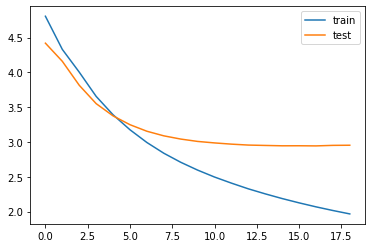

In [47]:
# 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

📰 수렴되는 모양을 보니 잘 학습된 것 같습니다.

---

## **04. 인퍼런스 모델 설계**

In [48]:
# 본문 변환
src_index_to_word = src_tokenizer.index_word

# 헤드라인 변환
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

print('Done!')

Done!


In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('Done!')

Done!


In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('Done!')

Done!


In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

print('Done!')

Done!


📰 좋습니다. 이제 모델을 테스트해볼까요?

---

## **05. 모델 테스트**

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('Done!')

Done!


📰 20개만 출력해보겠습니다.

In [126]:
for i in range(19):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : parliamentary standing committee transport tourism culture slammed private airlines passengers committee advised training given airline staff extending behaviour panel also noted airlines create long queues check counters passengers miss flights buy tickets next flight high prices 
실제 요약 : parliamentary committee slams airlines for rude behaviour 
예측 요약 :  airlines asked to remove parliamentary panel uniforms


원문 : dismissing rumours loans written finance minister arun jaitley said government waived loans big bad loan defaulters said cases instituted time bound recovery largest defaulters added government recognised previously concealed bad loans worth lakh crore scrutiny 
실제 요약 : loan waiver to is rumour fm arun jaitley 
예측 요약 :  banks cannot disclose banking sector banks jaitley


원문 : government planning link promotions ips officers physical fitness proposal regard circulated states union territories comments currently ips officers promoted based completion required years serv

📰 나름 괜찮게 요약된 것도 있고... 아닌 것도 꽤 보입니다.

아무래도 추상적 요약은 아직 조금 성능이 부족한 것 같습니다.

개선 방법은 여러 가지가 있겠지만, 일단 이번엔 다른 방식을 써보도록 하겠습니다.

---

## **06. 추출적 요약하기**

In [70]:
import requests
from summa.summarizer import summarize as sm

print('Done!')

Done!


In [128]:
# summa는 알아서 토크나이징을 합니다.
# 그러니까 본문만 넣어주면 되겠죠.
# 샘플 20개를 뽑아서 해봅시다.

data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
samples = data2.sample(20, ignore_index=True)

print(samples.shape)
samples.head()

(20, 2)


,headlines,text
0,'Iceball' planet discovered using host star's ...,Scientists have discovered an 'iceball' planet...
1,Video: SUV tossed in air after pipeline bursts...,A video showing an SUV being tossed in the air...
2,Congress objection to Protem Speaker is hoax: ...,After the Congress questioned the appointment ...
3,Railways earned Ã¢ÂÂ¹540 crore through flexi ...,Indian Railways has earned an additional reven...
4,Osama bin Laden's son marries daughter of lead...,"The son of Osama bin Laden, Hamza, has married..."


In [130]:
# 요약해봅시다.

for i in range(19):
    print('원문: ', samples['text'][i])
    print('헤드라인: ', samples['headlines'][i])
    print('요약 결과: ', sm(samples['text'][i], ratio=0.2))
    print('')

원문:  Scientists have discovered an 'iceball' planet, called so because of its star faintness, making it cold and uninhabitable. NASA's Spitzer Space Telescope made the discovery by planet transit method and microlensing. Microlensing uses the host star's gravity to focus background star's light and make it look brighter. A planet is then detected by measuring blips in the background star's brightness.
헤드라인:  'Iceball' planet discovered using host star's gravity
요약 결과:  

원문:  A video showing an SUV being tossed in the air after a pipeline burst in Mumbai's Borivali has surfaced online. Three other vehicles were damaged and over 35,000 litres of water was wasted after the 72-inch pipeline burst on Tuesday night, according to reports. The Brihanmumbai Municipal Corporation has begun repair work on the pipeline.
헤드라인:  Video: SUV tossed in air after pipeline bursts in Mumbai
요약 결과:  

원문:  After the Congress questioned the appointment of BJP MLA KG Bopaiah as the Protem Speaker in Karnata

📰 음? 빈 문장이 나오는군요.

ratio 설정의 문제일까요?

In [131]:
for i in range(19):
    print('원문: ', samples['text'][i])
    print('헤드라인: ', samples['headlines'][i])
    print('요약 결과: ', sm(samples['text'][i], ratio=0.4))
    print('')

원문:  Scientists have discovered an 'iceball' planet, called so because of its star faintness, making it cold and uninhabitable. NASA's Spitzer Space Telescope made the discovery by planet transit method and microlensing. Microlensing uses the host star's gravity to focus background star's light and make it look brighter. A planet is then detected by measuring blips in the background star's brightness.
헤드라인:  'Iceball' planet discovered using host star's gravity
요약 결과:  A planet is then detected by measuring blips in the background star's brightness.

원문:  A video showing an SUV being tossed in the air after a pipeline burst in Mumbai's Borivali has surfaced online. Three other vehicles were damaged and over 35,000 litres of water was wasted after the 72-inch pipeline burst on Tuesday night, according to reports. The Brihanmumbai Municipal Corporation has begun repair work on the pipeline.
헤드라인:  Video: SUV tossed in air after pipeline bursts in Mumbai
요약 결과:  A video showing an SUV bei

📰 흠, 여전히 빈칸이 있기는 하지만 일부 데이터들은 정상적으로 추출됩니다.

하지만 결과는 그리 좋지 않네요.

---

# **회고**

- **추상적 요약 결과**
---
    원문 : japanese company created gadget called body checks users body odour test smells near head 
    behind ears around feet rate three levels severity example detecting high readings smells gadget
    connected smartphone app would display immediately care needed 
 
    실제 요약 : company makes gadget to tell users if they smell bad 
    
    예측 요약 :  new york firm makes people that can detect heart heart
---
    원문 : fire broke monday camp akhada kumbh mela uttar pradesh reportedly gas cylinder
    exploded casualties injuries reported however several tents gutted fire crore people
    expected attend kumbh mela prayagraj begins january 
    
    실제 요약 : fire breaks out at camp day before kumbh mela in up 
    
    예측 요약 :  fire breaks out in up in bihar

- **추출적 요약 결과**
---
    원문:  Air India Chairman Ashwani Lohani in a letter to employees,
    said the corporate culture that comes with a new owner will help Air India compete globally.
    "The wonderful team of Air Indians, especially the licensed personnel should therefore have nothing to be sceptical about,"
    he added. Notably, an employees' union staged a protest at Delhi Airport on the same day.

    헤드라인:  New corporate culture will be good for Air India: Chairman

    요약 결과:  Air India Chairman Ashwani Lohani in a letter to employees,
    said the corporate culture that comes with a new owner will help Air India compete globally.

---
    원문:  South Korean cryptocurrency exchange Youbit has announced that it is shutting down
    and is filing for bankruptcy after it was hacked for the second time this year.
    The exchange announced that it had been hacked on Tuesday, causing a loss worth 17% of its total assets.
    nIt was hacked once before in April when reportedly around 4,000 Bitcoins were stolen. 
    
    헤드라인:  Korean cryptocurrency exchange to close after second hack
    
    요약 결과: (요약하지 못함)
---

- 추상적 요약은 동어반복을 하는 경우가 꽤 보입니다. 아마 인퍼런스 모델은 답을 모르고 가능성만 가지고 예측하니 그런 일이 벌어지는 것 같은데, 위에서 설계한 모델이 LSTM이니 밑시딥 풀잎스쿨에서 언급했던 PPMI 개념을 쓰면 해결할 수 있을 것 같습니다.

- 또, 생각보다 추출적 요약의 성능이 좋지 않습니다. 자체적인 tokenizer의 성능 문제인지는 몰라도 ratio 설정값에 따라 결과가 달라지는데, 긴 글이면 몰라도 뉴스 기사처럼 비교적 짧은 글에는 사용하기가 어려울 것으로 생각됩니다. 특히 추출된 결과를 보면 주로 첫 문장을 요약본으로 삼는 경향이 있는데, 물론 첫 문장이 중요하긴 하지만 항상 대표성을 지닌다고는 할 수 없습니다.

- 그래서 차라리 성능을 최대한 개선시킨 추상적 요약이 보편적으로 사용하기 편할 거라 생각됩니다. 일반적으로 인간이 생각하는 요약은 단순히 본문에서 '단어'만 추출하는 것이 아니라 새로운 문장을 써서라도 본문의 중심 '내용'을 작성하는 것이기 때문에, 추상적 요약의 메커니즘과도 잘 맞을 것 같습니다.

## **끝!**